# Corner detection and 3D calibration
Based on the tutorial [here](https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/sandbox/ludovic/aruco_calibration_rotation.html)

This is an improvement on the previous notebook. In this notebook, the stereo images are processed as pairs.   This is important because during the corner mapping, only the corners that appear in both images must be saved.  

In [7]:
import numpy as np
import cv2, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline

# The board
The following line of the board was updated to reflect the correct scale of the board.  This is necessary becuase the `board` object is used later   
`board = aruco.CharucoBoard_create(7, 5, .04026, .8*.04026, aruco_dict)`

Notice the board object returned.  Is contains all the magic of the CharUco pattern. For the image interpretation and to calibrate the cameras the cameras need a picture of the board and also information about the picture (ie. the details of the board).  This is all contained in the board object. 

In [8]:
board_size = 'experimental setup'
if board_size == '7x5':
    chessboard_num_squares_across = 7
    chessboard_num_squares_up = 5
    chessboard_square_size = 0.04026
    chessboard_aruco_ratio = 0.8   # this is a fraction of chessboard_square_size
    aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)


if board_size == '12x8':
    chessboard_num_squares_across = 12
    chessboard_num_squares_up = 8
    chessboard_square_size = 1
    chessboard_aruco_ratio = 0.7   # this is a fraction of chessboard_square_size
    aruco_dict = aruco.Dictionary_get(aruco.DICT_5X5_250)

elif board_size == 'experimental setup':   
    aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)





The board object contains all the vectors (pointing from the bottom left corner) to each of the corners present on the board.  The two kinds of objects are **aruco markers** and the **checkerboard**.  The aruco markers are called '`markers`' in the code and documentation.  The term `marker corners` means the set of 4 corners around each aruco maker. 

The aruco markers can be extracted from the board using the `aruco.getBoardObjectAndImagePoints(board, makerCorners command)`. 

Once the algorithm detected the markerCorners then it can interpolate between the marker corners to find the checkerboard corners.  The positions of checkerboard "inside" corners can be extracted using the folowing. 

The corners are labeled starting from 0 (bottom left) and going right 

# After taking many pictures of the board
This section of code groups the A and C images in an array of n sets x 2 pictures per set

In [11]:
datadir = "/Users/marcvanzyl/Desktop/HHH"


imagesL = np.array([datadir + f for f in os.listdir(datadir) if f.endswith(".jpeg") ])

orderL = np.argsort([int(p.split('/')[-1][:3]) for p in imagesL])

imagesL = imagesL[orderL]

# Combine the two lists into an array of 2 x n (n=the experiments) 
images = np.array(imagesL)

# but we want n X 2 so we transpose to create an array of nx2 
images = images.T

# check to see that the images align - look at the last image
images[-1]
# looks like all the images align because 39 on the left is with 39 on the right

ValueError: invalid literal for int() with base 10: 'HHH'

# Test the files and data

One issue with the images was that the contrast was not very high.  See above.  To improve the contrast I found this code online.  clipLimit is a variable that increases the contras

### Now using Charuco

This function:
1. finds the locations of the corners of the aruco squares (`cv2.aruco.detectMarkers`)
1. if markers were found interpolates to find the checkerboard markers between them (`cv2.aruco.interpolateCornersCharuco`)
1. zooms into each checkerboard corner to get sub-pixel accuracy using (`cv2.cornerSubPix`)

In [9]:
def find_checkerboard_corners(img, board, clipLimit=3.0, verbose=False):

    # These are parameters used by the cv2.cornerSubPix function
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    # increase the contraxt
    img = increase_contrast(img, clipLimit=clipLimit)
 
    # convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    detect_params = aruco.CORNER_REFINE_SUBPIX

    # find the aruco corners and the ids of each corner
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict, detect_params)
    
    if verbose:
        print('Found {} aruco marker corners'.format(len(ids)))
    
    if len(ids)>0:
        (retval, charucoCorners,
         charucoIds) = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, board, )
        if verbose:
            print('Found {} checker corners'.format(len(charucoIds)))
        if len(charucoIds)>0:
            # SUB PIXEL DETECTION
            for corner in charucoCorners:
                if verbose:
                    print('Sub pixel optimization:')
                    print(corner)
                cv2.cornerSubPix(gray, corner,
                                 winSize = (5,5),
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
                if verbose:
                    print(corner)
                    print('+++')
        
    return charucoCorners, charucoIds, gray.shape

        

One big problem is that you need to give the stereo calibration only coners that appear in both cameras.  Fortunately, the detection returns the ids of the corners in the `charucoIds`. These `charucoIds` correspond to the numbering system mentioned above (bottom left is 0 and starts going across to the right)

In [10]:
def find_common_corners(cornersL, idsL, cornersR, idsR, verbose=False):
    # find the list of corners common to both images
    # get a list of the ids
    listIdsL = idsL.reshape((1,-1))[0].tolist()
    listIdsR = idsR.reshape((1,-1))[0].tolist()
    
    # this selects only the points that are in listIdsA and listIdsC
    commonIds = list(set(listIdsL).intersection(set(listIdsR)))

    if verbose:
        print('Found {} common IDS between L:({}) and R:({})'.format(len(commonIds),
                                                                     len(idsL),
                                                                     len(idsR)))

    # Reindex L camera data by taking out only the common points 
    re_index = [ listIdsL.index(ind) for ind in commonIds]
    idsL_new = idsL[re_index]
    cornersL_new = np.array(cornersL)[re_index]
    cornersL_new = [x for x in cornersL_new]

    # Reindex R camera data by taking out only the common points
    re_index = [ listIdsR.index(ind) for ind in commonIds]
    idsR_new = idsR[re_index]
    cornersR_new = np.array(cornersR)[re_index]
    cornersR_new = [x for x in cornersR_new]

    return np.array(cornersL_new), idsL_new, np.array(cornersR_new), idsR_new

    

In [11]:
import pickle

cam_calOF = pickle.load( open('OFCameraCalibration.p', 'rb'))



In [12]:
cam_calOF.keys()

dict_keys(['camera_name', 'ret', 'mtx', 'dist', 'rvecs', 'tvecs'])

# Now we can check

## Camera features:
- sensor size = 3.68 x 2.76 mm  
- sensor resolution  = 3280 × 2464
- focal length = 3.04 mm

$$ d_{mm} = \frac{pix \times 3.68}{3280} $$

The depth can now be found
$$ Z = \frac{T \times f}{d_{mm}} $$

In [13]:
import pandas as pd

In [14]:
def find_charuco_marker_corners(img, aruco_dict, clipLimit=3.0, verbose=False):

    # These are parameters used by the cv2.cornerSubPix function
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 1e-11)

    # increase the contraxt
    #img = increase_contrast(img, clipLimit=clipLimit)


 
    # convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    

    # find the aruco corners and the ids of each corner
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)

    if verbose:
        print('Found {} aruco marker corners'.format(len(ids)))
        
    
    #  now find the central points of the aruco markers by averaging the four corner points
    if  len(ids) > 0:
        # SUB PIXEL DETECTION
        for corner in corners:
            if verbose:
                print('Sub pixel optimization:')
                print(corner)
            cv2.cornerSubPix(gray, corner,
                             winSize = (4,4),
                             zeroZone = (-1,-1),
                             criteria = criteria)
            if verbose:
                print(corner)
                print('+++')




    return np.array(corners), ids, gray.shape

        

In [15]:
def find_aruco_center(corners, ids):
    # find the center point of the 4 corner of the aruco markers
    centers = []
    for cnrs in corners:
        center = np.array((np.average(cnrs[0][:,0]), np.average(cnrs[0][:,1])))
        centers.append(center)
    centers = np.array(centers)
    centers = np.array(centers).reshape((-1,1,2))
    center_ids = np.arange(centers.shape[0]).reshape(-1,1)
    
    return centers, ids

In [16]:
image_number = 0

In [19]:
verbose =  True

centersAll = []
centersIdsAll = []

for image_number in range(len(images)):
    
    print('Image Number: {}'.format(image_number))
    print('Image File: {}'.format(images[image_number]))

    imgL = cv2.imread(images[image_number])

    # remap the images to rectify them
    imgL_rect = cv2.undistort(imgL,cam_calOF['mtx'],cam_calOF['dist'],None)

    charucoCornersL, charucoIdsL, imsize =  find_charuco_marker_corners(imgL_rect, 
                                                        aruco_dict, clipLimit=2.0, 
                                                        verbose=False, 
                                                        )




    centersL, center_idsL = find_aruco_center(charucoCornersL, charucoIdsL)
    
    centersAll.append(centersL)
    centersIdsAll.append(center_idsL)


    if verbose:
        x = centersL[:,0,0]
        y = centersL[:,0,1]

        annot_font = {'fontname':'Arial', 'size':'14','weight':'bold'}

        fig, axs = plt.subplots(figsize=(24,9))
        axs.imshow(imgL_rect)
        axs.scatter(x,y, color='r')
        for i, txt in enumerate(center_idsL.reshape(-1,)):
            axs.annotate('{}'.format(int(txt)), (x[i]+20, y[i]+30), color='g',  **annot_font)


        plt.show()

Image Number: 0
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/001.jpeg
Image Number: 1
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/002.jpeg
Image Number: 2
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/003.jpeg
Image Number: 3
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/004.jpeg
Image Number: 4
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/005.jpeg
Image Number: 5
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/006.jpeg
Image Number: 6
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/007.jpeg
Image Number: 7
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/008.jpeg
Image Number: 8
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/009.jpeg
Image Numb

Image Number: 74
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/075.jpeg
Image Number: 75
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/076.jpeg
Image Number: 76
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/077.jpeg
Image Number: 77
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/078.jpeg
Image Number: 78
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/079.jpeg
Image Number: 79
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/080.jpeg
Image Number: 80
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/081.jpeg
Image Number: 81
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/082.jpeg
Image Number: 82
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/083.jpeg
I

Image Number: 148
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/149.jpeg
Image Number: 149
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/150.jpeg
Image Number: 150
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/151.jpeg
Image Number: 151
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/152.jpeg
Image Number: 152
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/153.jpeg
Image Number: 153
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/154.jpeg
Image Number: 154
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/155.jpeg
Image Number: 155
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/156.jpeg
Image Number: 156
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/1

Image Number: 222
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/223.jpeg
Image Number: 223
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/224.jpeg
Image Number: 224
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/225.jpeg
Image Number: 225
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/226.jpeg
Image Number: 226
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/227.jpeg
Image Number: 227
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/228.jpeg
Image Number: 228
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/229.jpeg
Image Number: 229
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/230.jpeg
Image Number: 230
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/2

Image Number: 296
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/297.jpeg
Image Number: 297
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/298.jpeg
Image Number: 298
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/299.jpeg
Image Number: 299
Image File: /Users/gerrie/Google Drive/ScienceFair2/data/Test_3 (1)/Step_001/Run_003/300.jpeg


In [22]:
results = pd.DataFrame(columns=['Frame', 'ArucoId', 'XPos', 'YPos', 'Pos', 'File'])

for i, points in enumerate(centersAll):
    for j, point in enumerate(points): 
        ser = pd.Series()
        ser['File'] = "images[i]"
        ser['Frame'] = i
        ser['ArucoId'] = centersIdsAll[i][j][0]
        ser['Pos'] = point[0]
        ser['XPos'] = point[0][0]
        ser['YPos'] = point[0][1]

        #results = results.append(ser,ignore_index=True)
        results.loc[i*10+j] = ser
    

In [23]:
results.shape

(2989, 6)

In [24]:
results_003 = results.copy()

In [25]:
pickle.dump(results_003, open('results_003.p', 'wb'))

In [26]:
actual_distance = np.array([1169.66362686, 1405.20212069, 1654.65192714, 1912.57758013,
       2175.9671413 , 2443.05403133, 2531.44557732, 2531.73156376,
       2136.68322387, 2135.49530535])

## Camera features:
- sensor size = 3.68 x 2.76 mm  
- sensor resolution  = 3280 × 2464
- focal length = 3.04 mm

$$ d_{mm} = \frac{pix \times 3.68}{3280} $$

The depth can now be found
$$ Z = \frac{T \times f}{d_{mm}} $$

In the case of optical flow $T$ is the distance travelled between frames

In [27]:
camera_focal_length = 3.04
sensor_size_x = 3.68
sensor_resolution_x = 3280

In [28]:
actual_distance[0]

1169.66362686

In [29]:
results.shape

(2989, 6)

In [30]:
grp = results.groupby('ArucoId')

In [31]:
grp.groups.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 17])

In [32]:
results = results[results['ArucoId']<10]

In [33]:
results

,Frame,ArucoId,XPos,YPos,Pos,File
0,0,0,1304.500000,1750.750000,"[1304.5, 1750.75]",images[i]
1,0,1,1358.369751,1442.974365,"[1358.3698, 1442.9744]",images[i]
2,0,2,1393.544434,1235.431641,"[1393.5444, 1235.4316]",images[i]
3,0,3,1416.792358,1077.574463,"[1416.7924, 1077.5745]",images[i]
4,0,4,1439.045410,958.263367,"[1439.0454, 958.26337]",images[i]
...,...,...,...,...,...,...
2995,299,5,1784.201904,841.992920,"[1784.2019, 841.9929]",images[i]
2996,299,8,2636.769775,594.414185,"[2636.7698, 594.4142]",images[i]
2997,299,9,971.738464,542.096680,"[971.73846, 542.0967]",images[i]
2998,299,7,1929.265625,484.268982,"[1929.2656, 484.26898]",images[i]


In [34]:
col_index = pd.MultiIndex.from_tuples([('15mm/s', 'Distance'),('15mm/s', 'Error'),('15mm/s', 'Std Dev')], names=['Camera Speed', 'Metric'])
final =  pd.DataFrame(columns = col_index)


for step in range(1,6):
    # create the heading for the results dataframe
    speed_str = '{}mm/s'.format(step*15)
    # this is the distance the camera traveled each frame
    camera_distance = step
    
    step_results = results[results['Frame']%step == 0].copy()
    step_grp = step_results.groupby('ArucoId')
    for marker_id in step_grp.groups.keys():
        aruco_id = step_grp.get_group(marker_id)
        aruco_id['DisparityPixel'] = aruco_id['XPos'].diff()
        aruco_id['CameraSteps'] = aruco_id['Frame'].diff()/step    
        print(aruco_id.shape)

        aruco_id['DisparityPixelPerStep'] = aruco_id['DisparityPixel']
        aruco_id['DisparityMM'] = aruco_id['DisparityPixelPerStep']*sensor_size_x/sensor_resolution_x
        distance = camera_distance*camera_focal_length/aruco_id['DisparityMM'].mean()
        std_dev = camera_focal_length/aruco_id['DisparityMM'].std()/camera_distance
        error = (camera_distance*camera_focal_length/aruco_id['DisparityMM']) - actual_distance[marker_id]
        mean_error = error[abs(error)<1000 ].mean(skipna=True)
        std_dev_error = error[abs(error)<1000 ].std()

        final.loc[marker_id, (speed_str, 'Distance')] = round(distance,1)
        final.loc[marker_id, (speed_str, 'Error')] = round(mean_error,1)
        final.loc[marker_id, (speed_str, 'Std Dev')] = round(std_dev_error, 1)
        final.loc[marker_id, (speed_str, 'Max')] =  round(error[abs(error)<1000 ].max(), 1)
        final.loc[marker_id, (speed_str, 'Min')] = round(error[abs(error)<1000 ].min(),1)



/Users/gerrie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/gerrie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/gerrie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

(300, 8)
(300, 8)
(300, 8)
(300, 8)
(289, 8)
(300, 8)
(299, 8)
(300, 8)
(300, 8)
(300, 8)
(150, 8)
(150, 8)
(150, 8)
(150, 8)
(145, 8)
(150, 8)
(149, 8)
(150, 8)
(150, 8)
(150, 8)
(100, 8)
(100, 8)
(100, 8)
(100, 8)
(95, 8)
(100, 8)
(100, 8)
(100, 8)
(100, 8)
(100, 8)
(75, 8)
(75, 8)
(75, 8)
(75, 8)
(72, 8)
(75, 8)
(75, 8)
(75, 8)
(75, 8)
(75, 8)
(60, 8)
(60, 8)
(60, 8)
(60, 8)
(60, 8)
(60, 8)
(60, 8)
(60, 8)
(60, 8)
(60, 8)


In [35]:
final

Camera Speed   15mm/s                               30mm/s                 \
Metric       Distance Error Std Dev    Max    Min Distance  Error Std Dev   
0              1190.4  34.8   169.5  998.0 -473.5   1190.5   24.0    62.8   
1              1446.8    44    58.3  227.0 -158.0   1447.0   42.4    30.3   
2              1700.3  50.5    91.8  354.5 -248.4   1700.1   46.6    45.2   
3              1951.8  47.3   126.5  494.1 -378.8   1951.7   41.4    66.1   
4              2119.6  40.7   163.6  598.3 -376.9   2125.9   28.0    79.5   
5              2435.1   5.5     186  773.9 -511.9   2434.9   -5.1    85.2   
6              2422.5 -86.7   185.8  568.7 -566.8   2413.3  -98.3    90.5   
7              2453.5 -65.1     181  550.7 -541.0   2453.2  -75.0    93.7   
8                2047 -79.5   144.6  372.6 -463.7   2047.7  -85.4    86.3   
9              1950.1  -177   190.2  749.4 -931.2   1949.8 -178.7   119.6   

Camera Speed                ...   60mm/s                               \
Metric          Max    Min  ... Distance  Error Std Dev    Max    Min   
0             342.9 -225.4  ...   1190.2   21.6    35.7  176.7 -111.2   
1             138.9  -38.4  ...   1446.9   42.0    20.8   96.4   -2.1   
2             226.2  -93.3  ...   1699.9   45.6    25.7  103.3  -22.2   
3             221.4 -158.4  ...   1951.3   39.4    35.2  111.1  -78.2   
4             243.4 -147.2  ...   2111.1   25.2    47.8  178.0 -103.7   
5             233.2 -275.8  ...   2434.5   -7.3    53.9  127.0 -211.0   
6             114.5 -425.0  ...   2430.0 -100.0    59.3   22.2 -313.6   
7             312.0 -367.4  ...   2452.5  -78.0    53.3   35.8 -253.8   
8             173.8 -330.6  ...   2047.3  -88.5    41.9    7.1 -221.6   
9             291.5 -554.7  ...   1949.4 -183.8    66.9   27.1 -410.8   

Camera Speed   75mm/s                               
Metric       Distance  Error Std Dev    Max    Min  
0              1190.5   22.5    46.7  206.7 -109.8  
1              1447.1   42.1    17.8   76.4  -17.6  
2              1700.3   46.2    31.2  101.1  -67.2  
3              1952.1   40.2    36.4  115.2  -67.3  
4              2200.0   24.7    38.0  109.6  -87.7  
5              2435.1   -7.1    46.1   78.1 -191.5  
6              2430.4 -100.0    49.3   -2.1 -307.3  
7              2453.1  -77.8    45.8   -1.1 -262.5  
8              2047.3  -88.8    36.8  -25.3 -225.3  
9              1950.0 -184.5    45.3  -71.0 -363.1  

[10 rows x 25 columns]

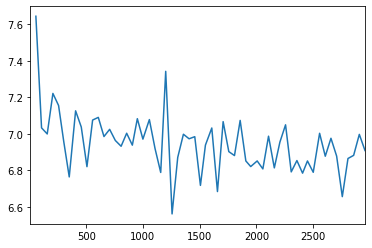

In [38]:
aruco_id['DisparityPixelPerStep'].plot()

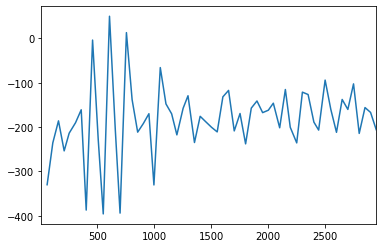

In [87]:
error.plot()

In [39]:
final.index.name = 'Target'

In [40]:
final

Camera Speed   15mm/s                               30mm/s                 \
Metric       Distance Error Std Dev    Max    Min Distance  Error Std Dev   
Target                                                                      
0              1190.4  34.8   169.5  998.0 -473.5   1190.5   24.0    62.8   
1              1446.8    44    58.3  227.0 -158.0   1447.0   42.4    30.3   
2              1700.3  50.5    91.8  354.5 -248.4   1700.1   46.6    45.2   
3              1951.8  47.3   126.5  494.1 -378.8   1951.7   41.4    66.1   
4              2119.6  40.7   163.6  598.3 -376.9   2125.9   28.0    79.5   
5              2435.1   5.5     186  773.9 -511.9   2434.9   -5.1    85.2   
6              2422.5 -86.7   185.8  568.7 -566.8   2413.3  -98.3    90.5   
7              2453.5 -65.1     181  550.7 -541.0   2453.2  -75.0    93.7   
8                2047 -79.5   144.6  372.6 -463.7   2047.7  -85.4    86.3   
9              1950.1  -177   190.2  749.4 -931.2   1949.8 -178.7   119.6   

Camera Speed                ...   60mm/s                               \
Metric          Max    Min  ... Distance  Error Std Dev    Max    Min   
Target                      ...                                         
0             342.9 -225.4  ...   1190.2   21.6    35.7  176.7 -111.2   
1             138.9  -38.4  ...   1446.9   42.0    20.8   96.4   -2.1   
2             226.2  -93.3  ...   1699.9   45.6    25.7  103.3  -22.2   
3             221.4 -158.4  ...   1951.3   39.4    35.2  111.1  -78.2   
4             243.4 -147.2  ...   2111.1   25.2    47.8  178.0 -103.7   
5             233.2 -275.8  ...   2434.5   -7.3    53.9  127.0 -211.0   
6             114.5 -425.0  ...   2430.0 -100.0    59.3   22.2 -313.6   
7             312.0 -367.4  ...   2452.5  -78.0    53.3   35.8 -253.8   
8             173.8 -330.6  ...   2047.3  -88.5    41.9    7.1 -221.6   
9             291.5 -554.7  ...   1949.4 -183.8    66.9   27.1 -410.8   

Camera Speed   75mm/s                               
Metric       Distance  Error Std Dev    Max    Min  
Target                                              
0              1190.5   22.5    46.7  206.7 -109.8  
1              1447.1   42.1    17.8   76.4  -17.6  
2              1700.3   46.2    31.2  101.1  -67.2  
3              1952.1   40.2    36.4  115.2  -67.3  
4              2200.0   24.7    38.0  109.6  -87.7  
5              2435.1   -7.1    46.1   78.1 -191.5  
6              2430.4 -100.0    49.3   -2.1 -307.3  
7              2453.1  -77.8    45.8   -1.1 -262.5  
8              2047.3  -88.8    36.8  -25.3 -225.3  
9              1950.0 -184.5    45.3  -71.0 -363.1  

[10 rows x 25 columns]

In [41]:
final_003 = final.copy()

In [2]:
import pickle

In [42]:
pickle.dump(final_003, open('of_final_003.p', 'wb'))